# Heatwaves workflow

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEATWAVES/main?labpath=HEATWAVES_notebook.ipynb)

The goal of this workflow is:
1. Look and the trends of the global warming and Heat-Days occurence 
2. Look at the climate scenarious for the future Heat-wave occurence
3. Identified the areas which are more susceptible to overheating, from the measured data

## Risk assessment methodology

Write here a description of the methodology.  

Describe the workflow and the data that is used.  

Desrcibe where the data can be found, is there an API to download it or the files can be downloaded from some data repository. Provide a link to the repository (as DOI if possible).

:::{tip} This workflow uses the following datasets:

- EURO-CORDEX climatic data for 2m air temperature 2026-2041 and instrumental period 2016-2020 from __[Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview)__   
- EURO-CORDEX Heat-wave projections (rcp 4.5 and rcp 8.5) from __[Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells)__   
- Climate variables for bigger cities in Europe (available __[here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-urban-climate-cities?tab=overview)__). This is a very high resolution dataset, but only for selcted cities.
- SENTINEL2 data for Vegetation characteristics available __[here](https://dataspace.copernicus.eu/browser/?zoom=3&lat=26&lng=0&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30)__
- LANDSAT8 land surface temperature for the 2016-2020 from __[Remote Sensing Lab](https://rslab.gr/downloads_LandsatLST.html)__
- Donscaled CMIP6 data from __[CHELSA dataset](https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F)__
::: 

And a cell with description of the work

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:

**Replace the libraries in the next two cells with the libraries used in the workflow**

### Load libraries

In this notebook we will use the following Python libraries:
- __[os](https://docs.python.org/3/library/os.html)__ - To create directories and work with files
- __[cdsapi](https://cds.climate.copernicus.eu/api-how-to)__ - To download the data from Climate Data Store
- __[pooch](https://www.fatiando.org/pooch/latest/index.html)__ - To download and unzip the data
- __[rasterio](https://rasterio.readthedocs.io/en/stable/)__ - To access and explore geospatial raster data in GeoTIFF format
- __[xarray](https://docs.xarray.dev/en/stable/)__ - To process the data and prepare it for damage calculation
- __[rioxarray](https://corteva.github.io/rioxarray/stable/)__ - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- __[cartopy](https://scitools.org.uk/cartopy/docs/latest/)__ - To plot the maps
- __[matplotlib](https://matplotlib.org/)__ - For plotting as well

In [1]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing

import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 

from osgeo import gdal # Geo data handling 

import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #

from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio

### Create the directory structure
In order for this workflow to work, we need to set up the directory structure.  
Next cell will create the directory called 'heat_workflow' in the same directory where this notebook is saved.  
Inside this directory we will create **data** and **resutls** directories, to store downloaded data and results.

In [12]:
workflow_folder = 'heat_workflow'
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results/')

if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(data_dir)
    os.makedirs(results_dir)    

### Download data

**You can keep the text below if you want to use pooch for downloading. Otherwise add a text about the API and delete the pooch bit.**

The data we are using is available as compressed ZIP files in the JRC data portal. 
Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

We can list all the files in the **data_dir** using the os library.  

In [3]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

tasmin_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20210101-20251231.nc
tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20210101-20251231.nc
.ipynb_checkpoints
cordex_t2m_2025.zip
tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20210101-20251231.nc


#### EURO-CORDEX climatic data for 2m air temperature 
First we need the climate data from EURO-CORDEX model.  
This data can be found in Climate Data Store, and downloaded using CDSapi.

:::{hint} New to CDS?
You can learn how to use it in __[this tutorial](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html)__.
:::

In [6]:
# Change KEY!!!
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "480:5297f06a-bfa1-4bbb-a0e5-3bb3e29485ef"
c = cdsapi.Client(url=URL, key=KEY)


DATADIR = data_dir
data = c.retrieve(
    "projections-cordex-domains-single-levels",
    {
           "domain": "europe",
           "experiment": "rcp_8_5",
           "horizontal_resolution": "0_11_degree_x_0_11_degree",
           "temporal_resolution": "daily_mean",
           "variable": [
               "2m_air_temperature", "maximum_2m_temperature_in_the_last_24_hours", "minimum_2m_temperature_in_the_last_24_hours",
           ],
           "gcm_model": "cnrm_cerfacs_cm5",
           "rcm_model": "clmcom_clm_cclm4_8_17",
           "ensemble_member": "r1i1p1",
            "start_year": [
                "2021",
            ],
            "end_year": [
                "2025"
            ],
           "format": "zip",
    },
   f"{DATADIR}/cordex_t2m_2025.zip")

2023-10-19 13:12:38,283 INFO Welcome to the CDS
2023-10-19 13:12:38,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-10-19 13:12:38,498 INFO Request is queued
2023-10-19 13:12:39,555 INFO Request is running
2023-10-19 13:15:30,158 INFO Request is completed
2023-10-19 13:15:30,160 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/dataset-projections-cordex-domains-single-levels-24c21808-71d4-4c0d-aa94-292228c28b48.zip to heat_workflow/data/era5_daily_t2m_eurminmax_2025.zip (1.9G)
2023-10-19 13:20:52,588 INFO Download rate 6.2M/s                                             


## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Euro-Cordex Tmean data

Explain the folder structure and file names.

All the downloaded files are stored in our **data_dir** folder, with filenames starting with: ...  
First we can explore one of them.

In [27]:
path_to_file = data_dir + '/cordex_t2m_2025.zip'
with zipfile.ZipFile(path_to_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [4]:
tm = f'{data_dir}/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20210101-20251231.nc'
dm=xr.open_dataset(tm)

We need some text what does decode_cf() do and why this was done.  
Do we need to do this for every dataset?

In [5]:
dm=xr.decode_cf(dm,decode_coords="all")
dm

<xarray.Dataset>
Dimensions:                     (time: 1826, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 2021-01-01T12:00:00 ......
    time_bnds                   (time, bnds) datetime64[ns] ...
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    tas                         (time, rlat, rlon) float32 ...
Attributes: (12/30)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    experiment_id:                  rcp85
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    ...                             ...
    table_id:                       Table day (Sept 2013) 0cf1782745489246c9f...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/7c62d578-9162-49ae-834d-32f9...
    c3s_disclaimer:                 This data has been produced in the contex...

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

Some data processing using xarray **removes the attributes of the data**. To stop xarray from doing that we need to set *keep_attrs* to true.

In [6]:
xr.set_options(keep_attrs=True)

In [7]:
da_m=dm['tas']
tas = da_m - 273.15
tas.attrs['units']='°C'

Note that tas is DataArray with the same attributes as tas in dm dataset.

In [8]:
tas

<xarray.DataArray 'tas' (time: 1826, rlat: 412, rlon: 424)>
array([[[ 19.195557 ,  19.1409   ,  19.134003 , ...,  18.807373 ,
          18.864166 ,  18.936493 ],
        [ 18.838531 ,  18.656342 ,  18.632812 , ...,  18.580292 ,
          18.652771 ,  18.796783 ],
        [ 18.4758   ,  18.184082 ,  18.014313 , ...,  18.406525 ,
          18.548615 ,  18.723083 ],
        ...,
        [ -7.564514 , -12.059448 ,  -9.305359 , ..., -33.048157 ,
         -37.300674 , -36.25052  ],
        [-12.169342 ,  -8.228973 ,  -7.559784 , ..., -36.87819  ,
         -37.23082  , -34.29567  ],
        [ -8.0633545,  -7.5420227,  -6.8194885, ..., -33.634064 ,
         -38.102615 , -34.655945 ]],

       [[ 17.991241 ,  17.95102  ,  17.928467 , ...,  18.005035 ,
          18.079529 ,  18.152924 ],
        [ 17.61856  ,  17.401733 ,  17.313446 , ...,  17.846588 ,
          17.944672 ,  18.071075 ],
        [ 17.41043  ,  17.021667 ,  16.754547 , ...,  17.755371 ,
          17.903625 ,  18.022888 ],
...
        [ -3.8564148,  -4.2886963,  -3.997223 , ..., -19.617126 ,
         -19.824814 , -19.358078 ],
        [ -4.145996 ,  -4.317688 ,  -3.9161682, ..., -19.992844 ,
         -21.93158  , -19.73227  ],
        [ -4.1823425,  -3.9905396,  -3.4543762, ..., -20.50354  ,
         -21.155792 , -20.504272 ]],

       [[ 21.080292 ,  20.895966 ,  20.73233  , ...,  22.422333 ,
          22.475067 ,  22.540985 ],
        [ 20.83545  ,  20.53125  ,  20.27005  , ...,  22.26831  ,
          22.314484 ,  22.406952 ],
        [ 20.654968 ,  20.278778 ,  19.819733 , ...,  22.074646 ,
          22.144958 ,  22.255646 ],
        ...,
        [ -3.2288208,  -3.6968079,  -3.6799316, ..., -20.464966 ,
         -20.100525 , -18.886963 ],
        [ -3.5525208,  -3.8182068,  -3.6731567, ..., -20.787094 ,
         -20.635101 , -19.213654 ],
        [ -3.7023315,  -3.6030273,  -3.2953796, ..., -20.472809 ,
         -20.792892 , -19.756882 ]]], dtype=float32)
Coordinates:
  * time                        (time) datetime64[ns] 2021-01-01T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

Next we calculate the monthly mean from the whole dataset.  
Note that month is an intiger number 1-12.

In [9]:
monthly_mean = tas.groupby('time.month').mean()
monthly_mean

<xarray.DataArray 'tas' (month: 12, rlat: 412, rlon: 424)>
array([[[ 18.622509  ,  18.592472  ,  18.588163  , ...,  21.063902  ,
          21.129995  ,  21.220308  ],
        [ 18.26273   ,  18.092901  ,  18.05329   , ...,  20.91154   ,
          21.004902  ,  21.139     ],
        [ 18.0044    ,  17.718945  ,  17.502743  , ...,  20.787666  ,
          20.933249  ,  21.068348  ],
        ...,
        [ -6.1944094 ,  -6.475886  ,  -6.690546  , ..., -22.349127  ,
         -22.37845   , -22.171711  ],
        [ -6.7674503 ,  -6.522729  ,  -6.64259   , ..., -22.56926   ,
         -22.795494  , -22.262661  ],
        [ -6.8084645 ,  -6.412474  ,  -5.861537  , ..., -22.566557  ,
         -23.289005  , -22.70444   ]],

       [[ 19.88105   ,  19.884375  ,  19.896303  , ...,  22.526577  ,
          22.600325  ,  22.700304  ],
        [ 19.64438   ,  19.558928  ,  19.557756  , ...,  22.377918  ,
          22.493069  ,  22.650583  ],
        [ 19.464262  ,  19.315533  ,  19.201124  , ...,  22.267162  ,
          22.449228  ,  22.622334  ],
...
        [ -2.8858118 ,  -3.5570345 ,  -3.5847254 , ..., -10.541399  ,
         -10.223025  ,  -9.287005  ],
        [ -3.675692  ,  -3.4785302 ,  -3.3834944 , ..., -10.434567  ,
         -10.625308  ,  -9.631051  ],
        [ -3.3475382 ,  -3.0058594 ,  -2.39909   , ..., -10.034862  ,
         -10.610325  , -10.033344  ]],

       [[ 19.926968  ,  19.891127  ,  19.870949  , ...,  23.38145   ,
          23.440163  ,  23.52485   ],
        [ 19.648916  ,  19.489117  ,  19.442106  , ...,  23.236422  ,
          23.329992  ,  23.450878  ],
        [ 19.44353   ,  19.191456  ,  18.977545  , ...,  23.111052  ,
          23.26346   ,  23.39022   ],
        ...,
        [ -4.136168  ,  -4.5528145 ,  -4.628633  , ..., -17.359104  ,
         -17.437115  , -16.88893   ],
        [ -4.820352  ,  -4.5256405 ,  -4.640969  , ..., -17.476418  ,
         -17.70533   , -16.989683  ],
        [ -4.7336445 ,  -4.3572855 ,  -3.732002  , ..., -17.18753   ,
         -17.94916   , -17.34242   ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

Finally we can plot the monthly mean for one month, for example May.

Text(0.5, 1.0, 'T monthly mean projection 2021-2025 for May')

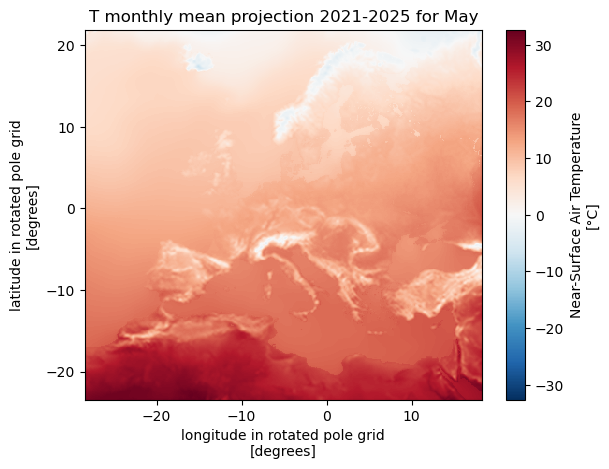

In [10]:
monthly_mean.sel(month=5).plot()
plt.title('T monthly mean projection 2021-2025 for May') 

We can save the monthly mean data into netcdf file. 
If we want to be able to work with this file using QGIS, we need to set the CRS to rotated pole projection, otherwise QGIS doesn't know how to interpret the data.

In [16]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
monthly_mean.rio.write_crs(rotated_pole, inplace=True)

<xarray.DataArray 'tas' (month: 12, rlat: 412, rlon: 424)>
array([[[ 18.622509  ,  18.592472  ,  18.588163  , ...,  21.063902  ,
          21.129995  ,  21.220308  ],
        [ 18.26273   ,  18.092901  ,  18.05329   , ...,  20.91154   ,
          21.004902  ,  21.139     ],
        [ 18.0044    ,  17.718945  ,  17.502743  , ...,  20.787666  ,
          20.933249  ,  21.068348  ],
        ...,
        [ -6.1944094 ,  -6.475886  ,  -6.690546  , ..., -22.349127  ,
         -22.37845   , -22.171711  ],
        [ -6.7674503 ,  -6.522729  ,  -6.64259   , ..., -22.56926   ,
         -22.795494  , -22.262661  ],
        [ -6.8084645 ,  -6.412474  ,  -5.861537  , ..., -22.566557  ,
         -23.289005  , -22.70444   ]],

       [[ 19.88105   ,  19.884375  ,  19.896303  , ...,  22.526577  ,
          22.600325  ,  22.700304  ],
        [ 19.64438   ,  19.558928  ,  19.557756  , ...,  22.377918  ,
          22.493069  ,  22.650583  ],
        [ 19.464262  ,  19.315533  ,  19.201124  , ...,  22.267162  ,
          22.449228  ,  22.622334  ],
...
        [ -2.8858118 ,  -3.5570345 ,  -3.5847254 , ..., -10.541399  ,
         -10.223025  ,  -9.287005  ],
        [ -3.675692  ,  -3.4785302 ,  -3.3834944 , ..., -10.434567  ,
         -10.625308  ,  -9.631051  ],
        [ -3.3475382 ,  -3.0058594 ,  -2.39909   , ..., -10.034862  ,
         -10.610325  , -10.033344  ]],

       [[ 19.926968  ,  19.891127  ,  19.870949  , ...,  23.38145   ,
          23.440163  ,  23.52485   ],
        [ 19.648916  ,  19.489117  ,  19.442106  , ...,  23.236422  ,
          23.329992  ,  23.450878  ],
        [ 19.44353   ,  19.191456  ,  18.977545  , ...,  23.111052  ,
          23.26346   ,  23.39022   ],
        ...,
        [ -4.136168  ,  -4.5528145 ,  -4.628633  , ..., -17.359104  ,
         -17.437115  , -16.88893   ],
        [ -4.820352  ,  -4.5256405 ,  -4.640969  , ..., -17.476418  ,
         -17.70533   , -16.989683  ],
        [ -4.7336445 ,  -4.3572855 ,  -3.732002  , ..., -17.18753   ,
         -17.94916   , -17.34242   ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref                 int64 0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

:::{note} How did we know which values to give to **pole_latitude** and **pole_longitude** parameters?
Scroll up and explore the coordinates of the **tm** dataset.  
You will notice the **grid_north_pole_latitude** and **grid_north_pole_longitude** coordinates, with a single value. Those are the values we need for CRS. 
:::

In [19]:
results_file = results_dir + 'mean_tas_2021-2025.nc'

In [20]:
monthly_mean.to_netcdf(path= results_file, mode='w', format='NETCDF4')

### Euro-Cordex T max for Heat-Wave
For The heat-wave we use the daily maximum temperature.

1. Load the data, then merge it to 2026-2040
2. Convert the unit from K to C
3. Calculate the maximum monthly means values
4. Set CRS to rotated pole
5. Save the data on the disk
6. Divide data to months = preparation for the Heat-wave segregation
7. Clip data to pilot site

In [22]:
# the data are for 5 year periods, you can select one which you prefer or merge all in one... 
tmax = f'{data_dir}/tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20210101-20251231.nc'
dmax=xr.open_dataset(tmax)
dmax=xr.decode_cf(dmax,decode_coords="all") ## https://docs.xarray.dev/en/stable/generated/xarray.open_dataarray.html

Now we explore the tmax dataset

In [23]:
dmax

<xarray.Dataset>
Dimensions:                     (time: 1826, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 2021-01-01T12:00:00 ......
    time_bnds                   (time, bnds) datetime64[ns] ...
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    tasmax                      (time, rlat, rlon) float32 ...
Attributes: (12/30)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    experiment_id:                  rcp85
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    ...                             ...
    table_id:                       Table day (Sept 2013) 0cf1782745489246c9f...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/2c7d0369-930d-4fa5-8747-62e0...
    c3s_disclaimer:                 This data has been produced in the contex...

In [24]:
dmax=dmax['tasmax']
tasmax=dmax - 273.15
#tasmax=tasmax.assign_attrs(dmax.attrs)
tasmax.attrs['units']='°C'
tasmax

<xarray.DataArray 'tasmax' (time: 1826, rlat: 412, rlon: 424)>
array([[[ 24.297546 ,  24.325073 ,  24.371948 , ...,  20.502045 ,
          20.628876 ,  20.813385 ],
        [ 24.300873 ,  24.344177 ,  24.392426 , ...,  20.178375 ,
          20.333801 ,  20.610992 ],
        [ 24.213531 ,  24.244476 ,  24.337341 , ...,  19.96637  ,
          20.215454 ,  20.528687 ],
        ...,
        [ -5.688568 ,  -8.512054 ,  -6.664276 , ..., -32.340897 ,
         -36.803513 , -34.925476 ],
        [ -8.373505 ,  -6.403534 ,  -4.71286  , ..., -36.268967 ,
         -36.50502  , -34.17685  ],
        [ -5.2989807,  -4.4571533,  -3.5115967, ..., -32.771713 ,
         -37.404984 , -34.472412 ]],

       [[ 23.889008 ,  23.88321  ,  23.897736 , ...,  18.45517  ,
          18.554901 ,  18.756622 ],
        [ 23.580566 ,  23.528412 ,  23.540558 , ...,  18.340637 ,
          18.553497 ,  18.826416 ],
        [ 23.36792  ,  23.272705 ,  23.247772 , ...,  18.452972 ,
          18.757385 ,  18.877014 ],
...
        [ -2.453827 ,  -2.918579 ,  -2.3214722, ..., -18.939224 ,
         -18.792175 , -17.574142 ],
        [ -2.6488953,  -2.8318481,  -2.1049194, ..., -19.18631  ,
         -19.306305 , -17.982513 ],
        [ -2.8701782,  -2.5567932,  -1.5413208, ..., -19.139557 ,
         -19.497986 , -18.63794  ]],

       [[ 25.813904 ,  25.648804 ,  25.510345 , ...,  23.289124 ,
          23.213287 ,  23.099579 ],
        [ 25.595184 ,  25.36737  ,  25.114105 , ...,  23.306213 ,
          23.204132 ,  23.050049 ],
        [ 25.370758 ,  25.169281 ,  24.7695   , ...,  23.29129  ,
          23.159058 ,  22.91809  ],
        ...,
        [ -1.8467712,  -2.6154785,  -2.5704956, ..., -18.96907  ,
         -18.818329 , -17.571793 ],
        [ -2.1203308,  -2.7398682,  -2.7884827, ..., -19.188583 ,
         -19.306015 , -17.979004 ],
        [ -2.3177795,  -2.507141 ,  -2.2997742, ..., -19.150085 ,
         -19.476883 , -18.623413 ]]], dtype=float32)
Coordinates:
  * time                        (time) datetime64[ns] 2021-01-01T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    units:             °C
    cell_methods:      time: maximum
    history:           2014-03-26T13:11:28Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

In [25]:
max_monthly_mean = tasmax.groupby('time.month').mean(keep_attrs=True)
max_monthly_mean

<xarray.DataArray 'tasmax' (month: 12, rlat: 412, rlon: 424)>
array([[[ 24.791224 ,  24.828312 ,  24.871483 , ...,  22.00245  ,
          22.077751 ,  22.183598 ],
        [ 24.64673  ,  24.674936 ,  24.717054 , ...,  21.8998   ,
          22.002987 ,  22.14298  ],
        [ 24.46209  ,  24.465773 ,  24.509531 , ...,  21.828468 ,
          21.980577 ,  22.113646 ],
        ...,
        [ -4.734712 ,  -4.9278193,  -4.856706 , ..., -20.25653  ,
         -20.374525 , -20.277205 ],
        [ -5.191827 ,  -4.9390993,  -4.731564 , ..., -20.558128 ,
         -20.812586 , -20.35548  ],
        [ -5.3494515,  -4.935752 ,  -4.211847 , ..., -20.579988 ,
         -21.341087 , -20.793468 ]],

       [[ 26.107449 ,  26.1589   ,  26.212326 , ...,  23.469728 ,
          23.550253 ,  23.647322 ],
        [ 26.073875 ,  26.147203 ,  26.204313 , ...,  23.35418  ,
          23.47123  ,  23.618017 ],
        [ 26.005774 ,  26.099112 ,  26.211952 , ...,  23.278631 ,
          23.449755 ,  23.612465 ],
...
        [ -1.6817296,  -2.2338068,  -1.9741882, ...,  -8.755292 ,
          -8.388457 ,  -7.433078 ],
        [ -2.3958094,  -2.1266797,  -1.8369693, ...,  -8.681751 ,
          -8.817918 ,  -7.8040624],
        [ -2.1594794,  -1.7907274,  -1.0635421, ...,  -8.251589 ,
          -8.805202 ,  -8.195435 ]],

       [[ 25.48806  ,  25.49718  ,  25.51876  , ...,  24.292723 ,
          24.345228 ,  24.442112 ],
        [ 25.372463 ,  25.374825 ,  25.388422 , ...,  24.196753 ,
          24.276833 ,  24.393948 ],
        [ 25.22299  ,  25.207842 ,  25.226946 , ...,  24.122213 ,
          24.24925  ,  24.366476 ],
        ...,
        [ -3.069536 ,  -3.3487668,  -3.1854944, ..., -15.638343 ,
         -15.617425 , -15.144659 ],
        [ -3.651739 ,  -3.257388 ,  -3.0379634, ..., -15.738603 ,
         -15.919624 , -15.284852 ],
        [ -3.5680625,  -3.148762 ,  -2.3857338, ..., -15.441063 ,
         -16.208582 , -15.608215 ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    units:             °C
    cell_methods:      time: maximum
    history:           2014-03-26T13:11:28Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

Text(0.5, 1.0, 'T monthly mean projection 2021-2025 for May')

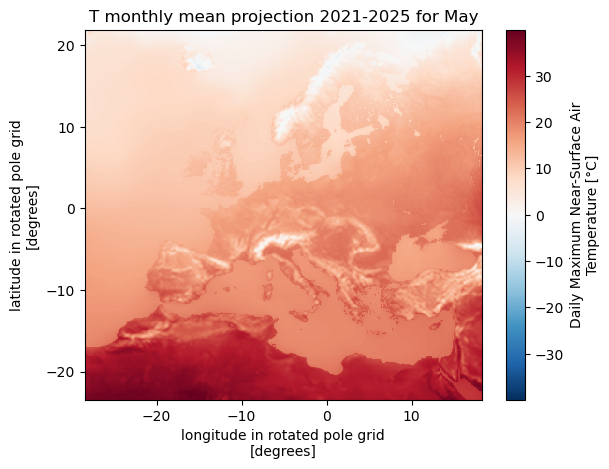

In [26]:
max_monthly_mean.sel(month=5).plot()
plt.title('T monthly mean projection 2021-2025 for May')

In [27]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
max_monthly_mean.rio.write_crs(rotated_pole, inplace=True)

results_file = results_dir + 'mean_tasmax_2021-2025.nc'
max_monthly_mean.to_netcdf(path=results_file, mode='w', format='NETCDF4')

## Process the data


In [31]:
tasmax_month=tasmax.groupby('time.month').groups
jun_idxs=tasmax_month[6]
jul_idxs=tasmax_month[7]
aug_idxs=tasmax_month[8]

jun_max=tasmax.isel(time=jun_idxs)
jul_max=tasmax.isel(time=jul_idxs)
aug_max=tasmax.isel(time=aug_idxs)

In [42]:
condition = tasmax['time.month'] == 5
ds_nc_modified = tasmax.where(condition, drop=True)
ds_nc_modified

<xarray.DataArray 'tasmax' (time: 155, rlat: 412, rlon: 424)>
array([[[ 36.443756  ,  36.523346  ,  36.60971   , ...,  27.325287  ,
          27.31189   ,  27.364655  ],
        [ 36.487396  ,  36.58609   ,  36.66867   , ...,  27.23233   ,
          27.26535   ,  27.32611   ],
        [ 36.484467  ,  36.626007  ,  36.776184  , ...,  27.144012  ,
          27.284973  ,  27.357147  ],
        ...,
        [  0.9507446 ,   0.92767334,   1.631897  , ...,  -4.488312  ,
          -3.2131653 ,  -1.23349   ],
        [  0.76916504,   1.0064087 ,   2.0238953 , ...,  -4.4536743 ,
          -3.7043762 ,  -1.8119507 ],
        [  0.8439026 ,   1.5735168 ,   5.0825195 , ...,  -3.6411438 ,
          -3.6513672 ,  -2.3188171 ]],

       [[ 37.08615   ,  37.132538  ,  37.18701   , ...,  27.965912  ,
          27.98053   ,  28.03775   ],
        [ 37.141327  ,  37.221252  ,  37.275146  , ...,  27.877197  ,
          27.940247  ,  28.060608  ],
        [ 37.11029   ,  37.245483  ,  37.382355  , ...,  27.819305  ,
          27.996948  ,  28.13208   ],
...
        [  1.3064575 ,   1.0933533 ,   3.6951904 , ...,   4.7979126 ,
           5.1676636 ,   6.4745483 ],
        [  0.8381958 ,   1.0105286 ,   4.1325684 , ...,   4.381012  ,
           5.0856934 ,   6.8494873 ],
        [  0.53933716,   0.82162476,   4.3561707 , ...,   4.5226746 ,
           4.944916  ,   6.2784424 ]],

       [[ 35.29657   ,  35.610504  ,  35.780334  , ...,  28.734192  ,
          28.833008  ,  28.957489  ],
        [ 35.127045  ,  35.514954  ,  35.85498   , ...,  28.583588  ,
          28.706482  ,  28.89392   ],
        [ 34.961456  ,  35.3356    ,  35.82953   , ...,  28.571533  ,
          28.758118  ,  28.957642  ],
        ...,
        [  0.543396  ,   0.68963623,   2.1036682 , ...,   2.3902283 ,
           2.8335266 ,   3.0210571 ],
        [  0.5010681 ,   1.201355  ,   3.8544922 , ...,   2.506836  ,
           2.4492188 ,   3.130066  ],
        [  0.49368286,   1.2445984 ,   4.6505737 , ...,   2.7963257 ,
           2.2338257 ,   2.8598328 ]]], dtype=float32)
Coordinates:
  * time                        (time) datetime64[ns] 2021-05-01T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 -2147483647
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 2.0
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    units:             °C
    cell_methods:      time: maximum
    history:           2014-03-26T13:11:28Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

In [40]:
tasmax['time.month']

<xarray.DataArray 'month' (time: 1826)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time                        (time) datetime64[ns] 2021-01-01T12:00:00 ......
    rotated_latitude_longitude  int32 ...
    height                      float64 ...

:::{tip} Here's an example text:

If we have a closer look at the x and y dimensions of the datasets, we can see that the data has different resolutions. Flood extent maps are at 100 m resolution, while land use data is at 1km. We can use xarray to get them to the same resolution.  

But first we need to clip them to the same area, so we don't interpolate the whole global field.   

For this we use the rioxarray library again.  
**minx** and **maxx** are longitudes, and **miny** and **maxy** are latitudes of the bounding box.  

In this example we are clipping the bounding box around city of Zilina in Slovakia.
:::

In [6]:
xmin=18
ymin=48
xmax=20
ymax=50

In [4]:
# code cell with processing

#### Explanation of the processing step I

Explain the processing step, what library is used and why.  
Try to include links to the documentation about the functions you are using.

:::{tip} Here's an example text:
#### Interpolate the land use data array

Next we need to interpolate the land use data into the flood map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

Since we don't really want interpolate the values, we are using method **'nearest'**, to assing the values of the nearest grid points.

:::

In [5]:
# code cell with processing, for example:
#flood_200_small_area_1km  = flood_200_small_area.interp_like(land_use_small_area, method='nearest')
#flood_200_small_area_1km

You may include a simple plot to quickly visualise the result. But make sure to explain what is plotted

In [6]:
#flood_200_small_area_1km.plot()

## Calculate the indices

Calculating some indices using the processed data is often part of the workflow. 

- Explain here what is calculated, include the links to the documentation about the methond.
- Explain what libraries are used and include link to the documentation
- Explain clearly what input fields are
- Explain which functions are used and possibly their parameters
- Explain what the output is

In [8]:
# code for the calculation

In [7]:
# another code cell

## Plot the results

Plot the results. Explain what libray is used and provide the link if it is not already there.

If the plotting code is large, break it into more cells and explain each part.

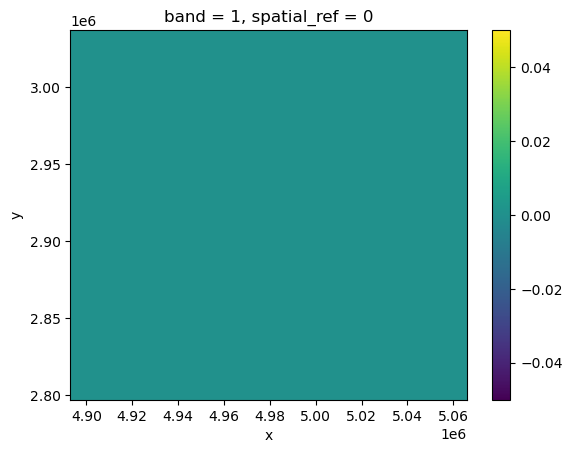

In [31]:
damagemap = rxr.open_rasterio('scenario_damagemap.tif')
damagemap.plot()

## Conclusions

Some text about conclusions and lessons learned

## Contributors
authors, links to libraries documentation, references etc